In [33]:
#importing the libraries
import os
from IPython.display import Image
import re
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#setting base directory locations
BASE_DIR = r"D:/Diploma/datasets/"
IMAGE_DIR = r"NLMCXR_png"
REPORT_DIR = r"ecgen-radiology"

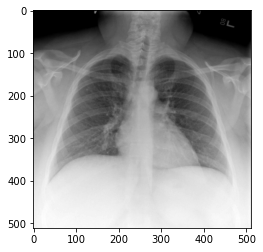

In [3]:
#Displaying random sample image from dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline 

rand_img = random.choice(os.listdir(f'{BASE_DIR}/{IMAGE_DIR}'))
image = cv2.imread(f"{BASE_DIR}/{IMAGE_DIR}/{rand_img}", 0) 
plt.imshow(image, cmap='gray')
   

In [4]:
#dispalying sample xml report file
with open(f"{BASE_DIR}/{REPORT_DIR}/1.xml", 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

In [5]:
print('Total X-rays Images in dataset are ', len(os.listdir(f'{BASE_DIR}/{IMAGE_DIR}')))
print("Total docter's Reports in dataset are ", len(os.listdir(f"{BASE_DIR}/{REPORT_DIR}")))

Total X-rays Images in dataset are  7471
Total docter's Reports in dataset are  3955


# Making the pandas dataframe from XML report's data

In [6]:
cols = ["findings","indication","comparison", "impression", "caption","image_id"]
df = pd.DataFrame(columns=cols)
for xmlfile in os.listdir(f"{BASE_DIR}/{REPORT_DIR}"):

    tree = ET.parse(f"{BASE_DIR}/{REPORT_DIR}/" + xmlfile)  # parse the xml file

    finding_data = tree.find(".//AbstractText[@Label='FINDINGS']").text
    indication_data = tree.find(".//AbstractText[@Label='INDICATION']").text
    comparision_data = tree.find(".//AbstractText[@Label='COMPARISON']").text
    impression_data = tree.find(".//AbstractText[@Label='IMPRESSION']").text

    doc_caption = []
    img_name = []
    for imgage in tree.findall("parentImage"):
        img = imgage.attrib['id'] + ".png"
        img_name.append(img)
        # add the corresponding report for each image
        doc_caption.append('' if imgage.find('caption').text is None else imgage.find('caption').text)
    df = df.append(
        pd.Series([finding_data, indication_data, comparision_data,impression_data,','.join(doc_caption),','.join(img_name)],
                  index=cols), ignore_index=True)


# Printing missing data statistics 

In [7]:
total_data = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total_data, percentage], axis=1, keys=['Total_items', 'Missing_data_Percent'])
missing_data

,Total_items,Missing_data_Percent
comparison,622,15.726928
findings,530,13.400759
indication,90,2.275601
impression,34,0.859671
caption,0,0.000000
image_id,0,0.000000


# Filling missing values

In [8]:
#Replacing the nan values
df['comparison'] = df['comparison'].fillna('No Comparison')
df['impression'] = df['impression'].fillna('No Impression')
df['indication'] = df['indication'].fillna('No Indication')
df['findings'] = df['findings'].fillna('No Findings')
df['image_id'] = df['image_id'].fillna('No Image')

## Data preprocessing

In [9]:
#function for data decontraction 
def data_decontraction(value):
    value = re.sub(r"won\'t", "will not", value)
    value = re.sub(r"\'re", " are", value)
    value = re.sub(r"can\'t", "can not", value)
    value = re.sub(r"n\'t", " not", value)
    value = re.sub(r"\'s", " is", value)
    value = re.sub(r"\'d", " would", value)
    value = re.sub(r"\'ll", " will", value)
    value = re.sub(r"\'t", " not", value)
    value = re.sub(r"\'ve", " have", value)
    value = re.sub(r"\'m", " am", value)
    return value

In [10]:
def data_preprocessing(df):
    data = []
    for val in df.values:
        val = val.lower()
        val = re.sub(r"x-xxxx","",val)
        val = re.sub(r"xxxx","",val)
        val = re.sub('[^A-Za-z]+', ' ', val)
        val = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", val)
        val = re.sub(r"\d." ,"",val)
        val = re.sub(r"X+" ,"",val)
        val = re.sub(r"http\S+" ,"",val)
        val = re.sub('year old',"",val)
        val = data_decontraction(val)
        data.append(val.strip())
    return data

In [11]:
df['comparison'] = data_preprocessing(df['comparison'])
df['indication'] = data_preprocessing(df['indication'])
df['findings'] = data_preprocessing(df['findings'])
df['impression'] = data_preprocessing(df['impression'])

## We can replace the data point which are not having image data

In [12]:
df.replace("", float("NaN"), inplace=True)
df.dropna(subset = ["image_id"], inplace=True)


In [13]:
df.shape

(3851, 6)

In [14]:
df.head()

,findings,indication,comparison,impression,caption,image_id
0,the cardiac silhouette and mediastinum size ar...,positive tb test,none,normal chest,"Xray Chest PA and Lateral,Xray Chest PA and La...","CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png"
1,the cardiomediastinal silhouette is within nor...,male chest pain,chest radiographs,no acute cardiopulmonary process,"PA and lateral chest x-XXXX XXXX. ,PA and late...","CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png"
2,both lungs are clear and expanded heart and me...,no indication,none,no active disease,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM ,...","CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png"
3,there is increased opacity within the right up...,male,pa and lateral chest radiographs,increased opacity in the right upper lobe with...,"PA and lateral chest x-XXXX XXXX. ,PA and late...","CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001...."
4,interstitial markings are diffusely prominent ...,dyspnea subjective fevers arthritis immigrant ...,none,diffuse fibrosis no visible focal acute disease,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM,CH...","CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png"


## EDA on Image data

In [15]:
#getting details of images associated with report
df['total_image'] = df['image_id'].astype(str).apply(lambda x: x.split(',') if x else None).apply(lambda x: 0 if not x else len(x))
print ("Maximum number of images associated with one data point is: "+ str(df['total_image'].max()))
print ("Minimum number of images associated with one data point is: "+ str(df['total_image'].min()))
print ("mean number of images associated with one data point is: "+ str(df['total_image'].mean()))
print ("median number of images associated with one data point is: "+ str(df['total_image'].median()))

Maximum number of images associated with one data point is: 5
Minimum number of images associated with one data point is: 1
mean number of images associated with one data point is: 1.9397559075564788
median number of images associated with one data point is: 2.0


In [17]:
print('number of images associated with each report: \n'+ str(df['total_image'].value_counts()))

number of images associated with each report: 
2    3208
1     446
3     181
4      15
5       1
Name: total_image, dtype: int64


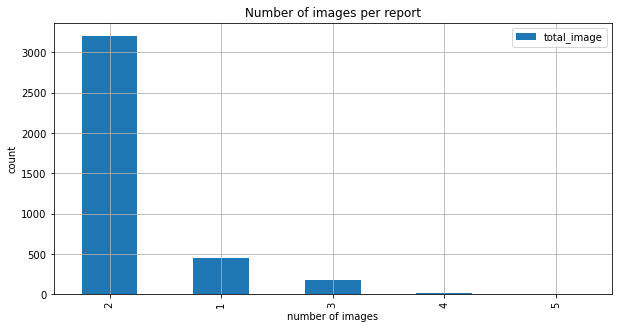

In [18]:
#printing chart 
df['total_image'].value_counts().plot(figsize = (10,5),kind = 'bar',legend =True,grid =True,title='Number of images per report')
plt.xlabel('number of images')
plt.ylabel('count')
plt.show()

## EDA on the Text data

## Missing values in Comparision

In [26]:
#missing value in comparision
print("rows which are not having information of camparision is: "+str(df.loc[(df['comparison'] == 'none') | (df['comparison'] == 'no comparison')].shape[0]))

rows which are not having information of camparision is: 2005


## Impression data analysis

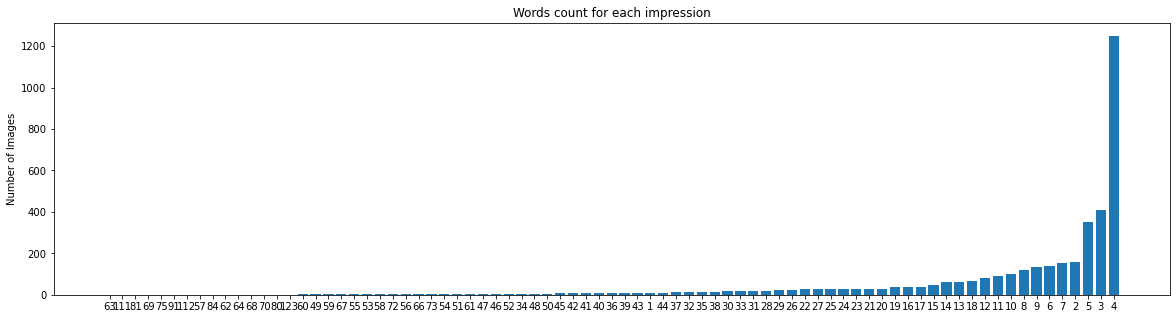

In [28]:
word_count = df['impression'].str.split().apply(len).value_counts()
wc_dict = dict(word_count)
wc_dict = dict(sorted(wc_dict.items(), key=lambda kv: kv[1]))


id = np.arange(len(wc_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(id, list(wc_dict.values()))

plt.ylabel('Number of Images')
plt.title('Words count for each impression')
plt.xticks(id, list(wc_dict.keys()))
plt.show()

C:\Users\Tiaa User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


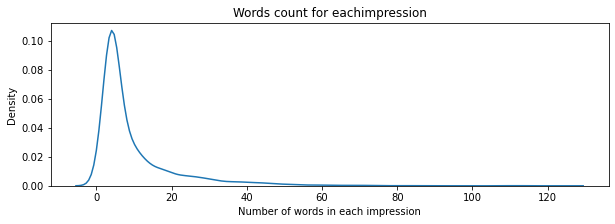

In [30]:
plt.figure(figsize=(10,3))
sns.distplot(df['impression'].str.split().apply(len).values, hist=False)
plt.title('Words count for each impression')
plt.xlabel('Number of words in each impression')
plt.show()

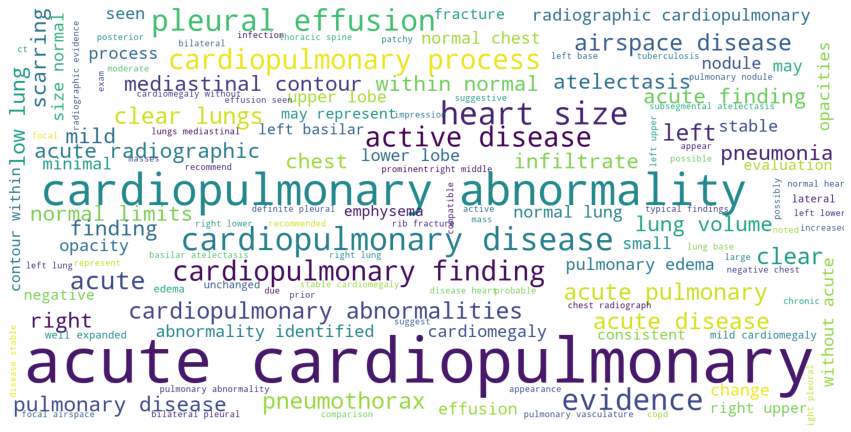

In [46]:
# printing wordcloud for impression data
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=500,
        max_font_size=30, 
        scale=4,
        random_state=1 
).generate(' '.join(data.astype(str)))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
wordcloud(df['impression'])

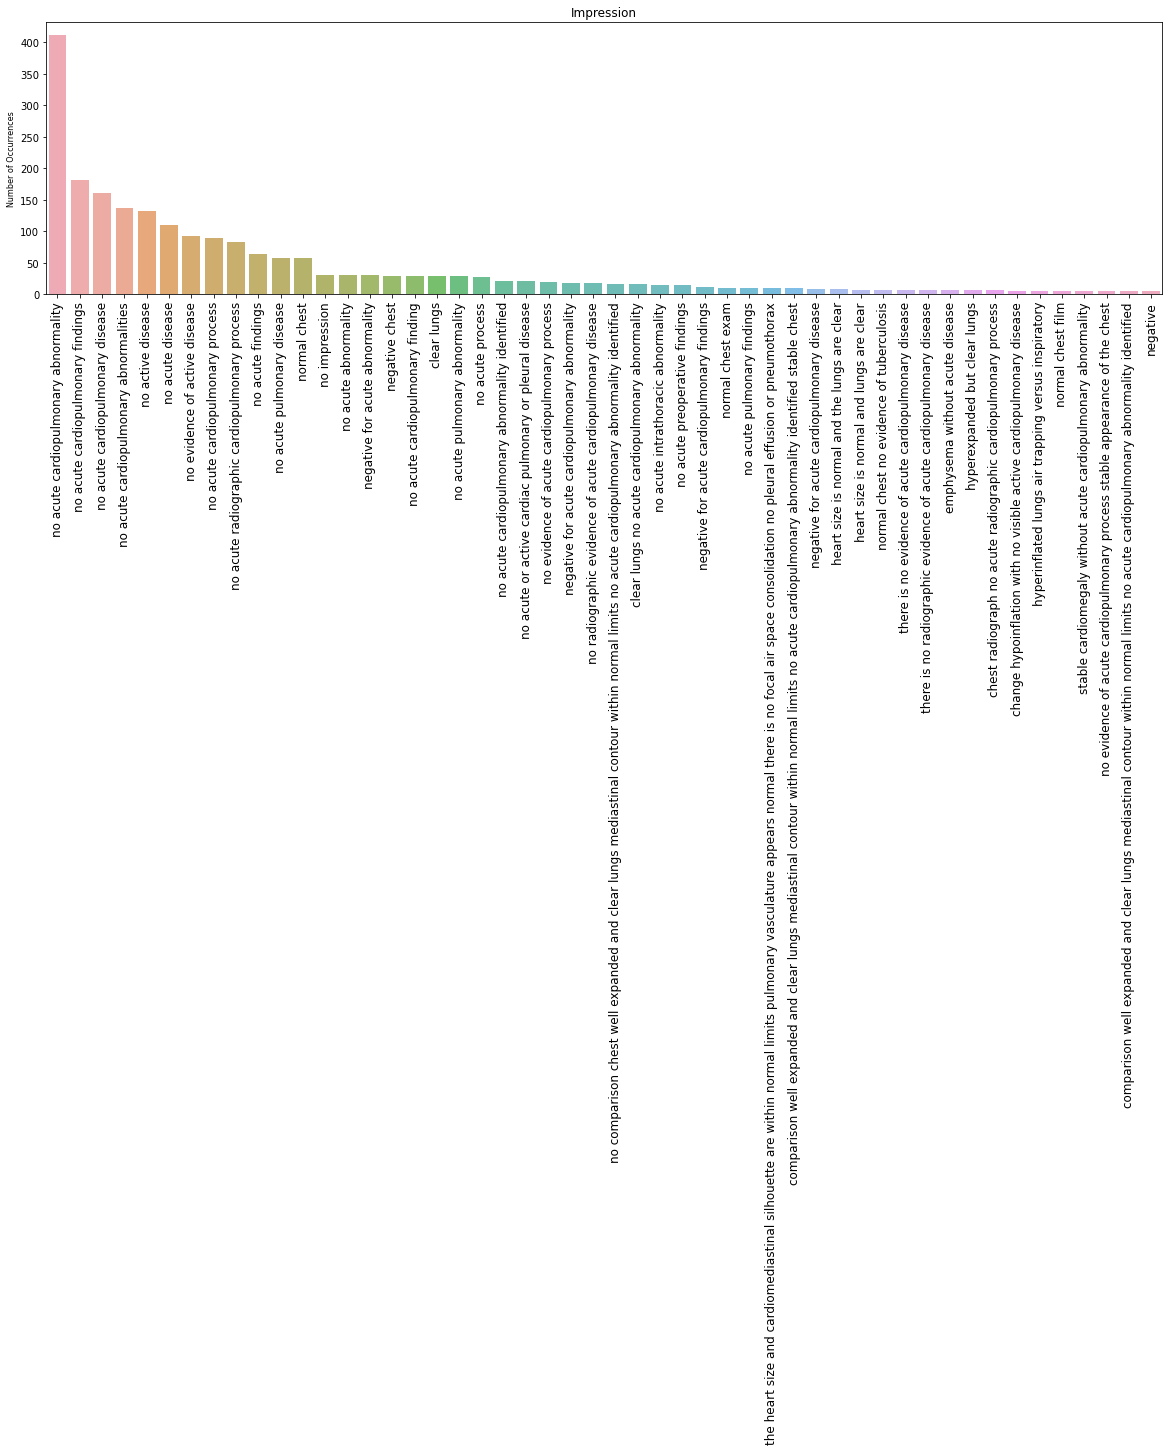

In [52]:
text = df['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(text.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=8)
plt.xticks(fontsize='large',rotation=90)
plt.title("Impression")
plt.show()

## Findings data analysis

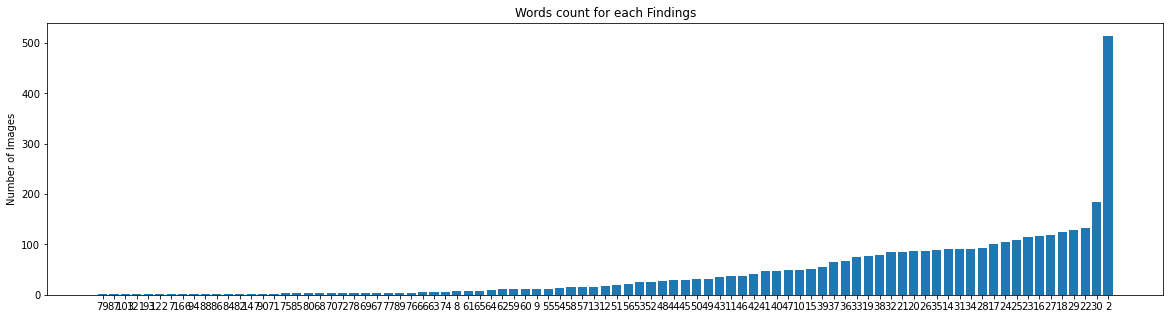

In [42]:
word_count = df['findings'].str.split().apply(len).value_counts()
wc_dict = dict(word_count)
wc_dict = dict(sorted(wc_dict.items(), key=lambda kv: kv[1]))


id = np.arange(len(wc_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(id, list(wc_dict.values()))

plt.ylabel('Number of Images')
plt.title('Words count for each Findings')
plt.xticks(id, list(wc_dict.keys()))
plt.show()

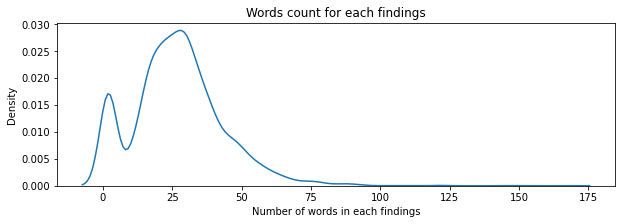

In [43]:
plt.figure(figsize=(10,3))
sns.distplot(df['findings'].str.split().apply(len).values, hist=False)
plt.title('Words count for each findings')
plt.xlabel('Number of words in each findings')
plt.show()

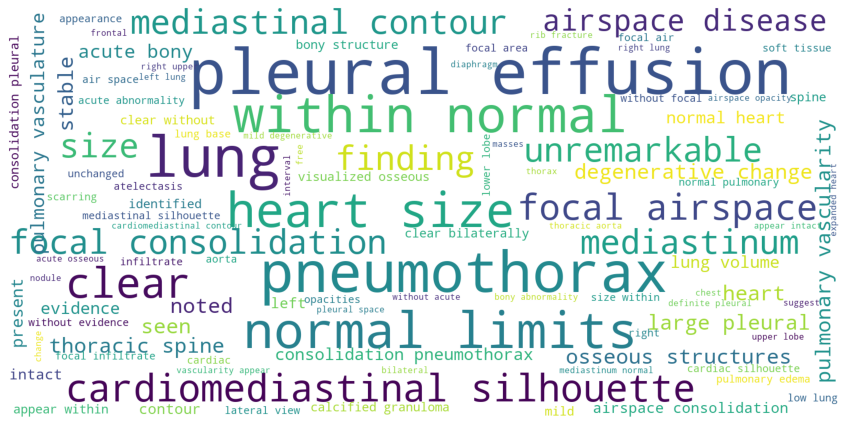

In [45]:
wordcloud(df['findings'])

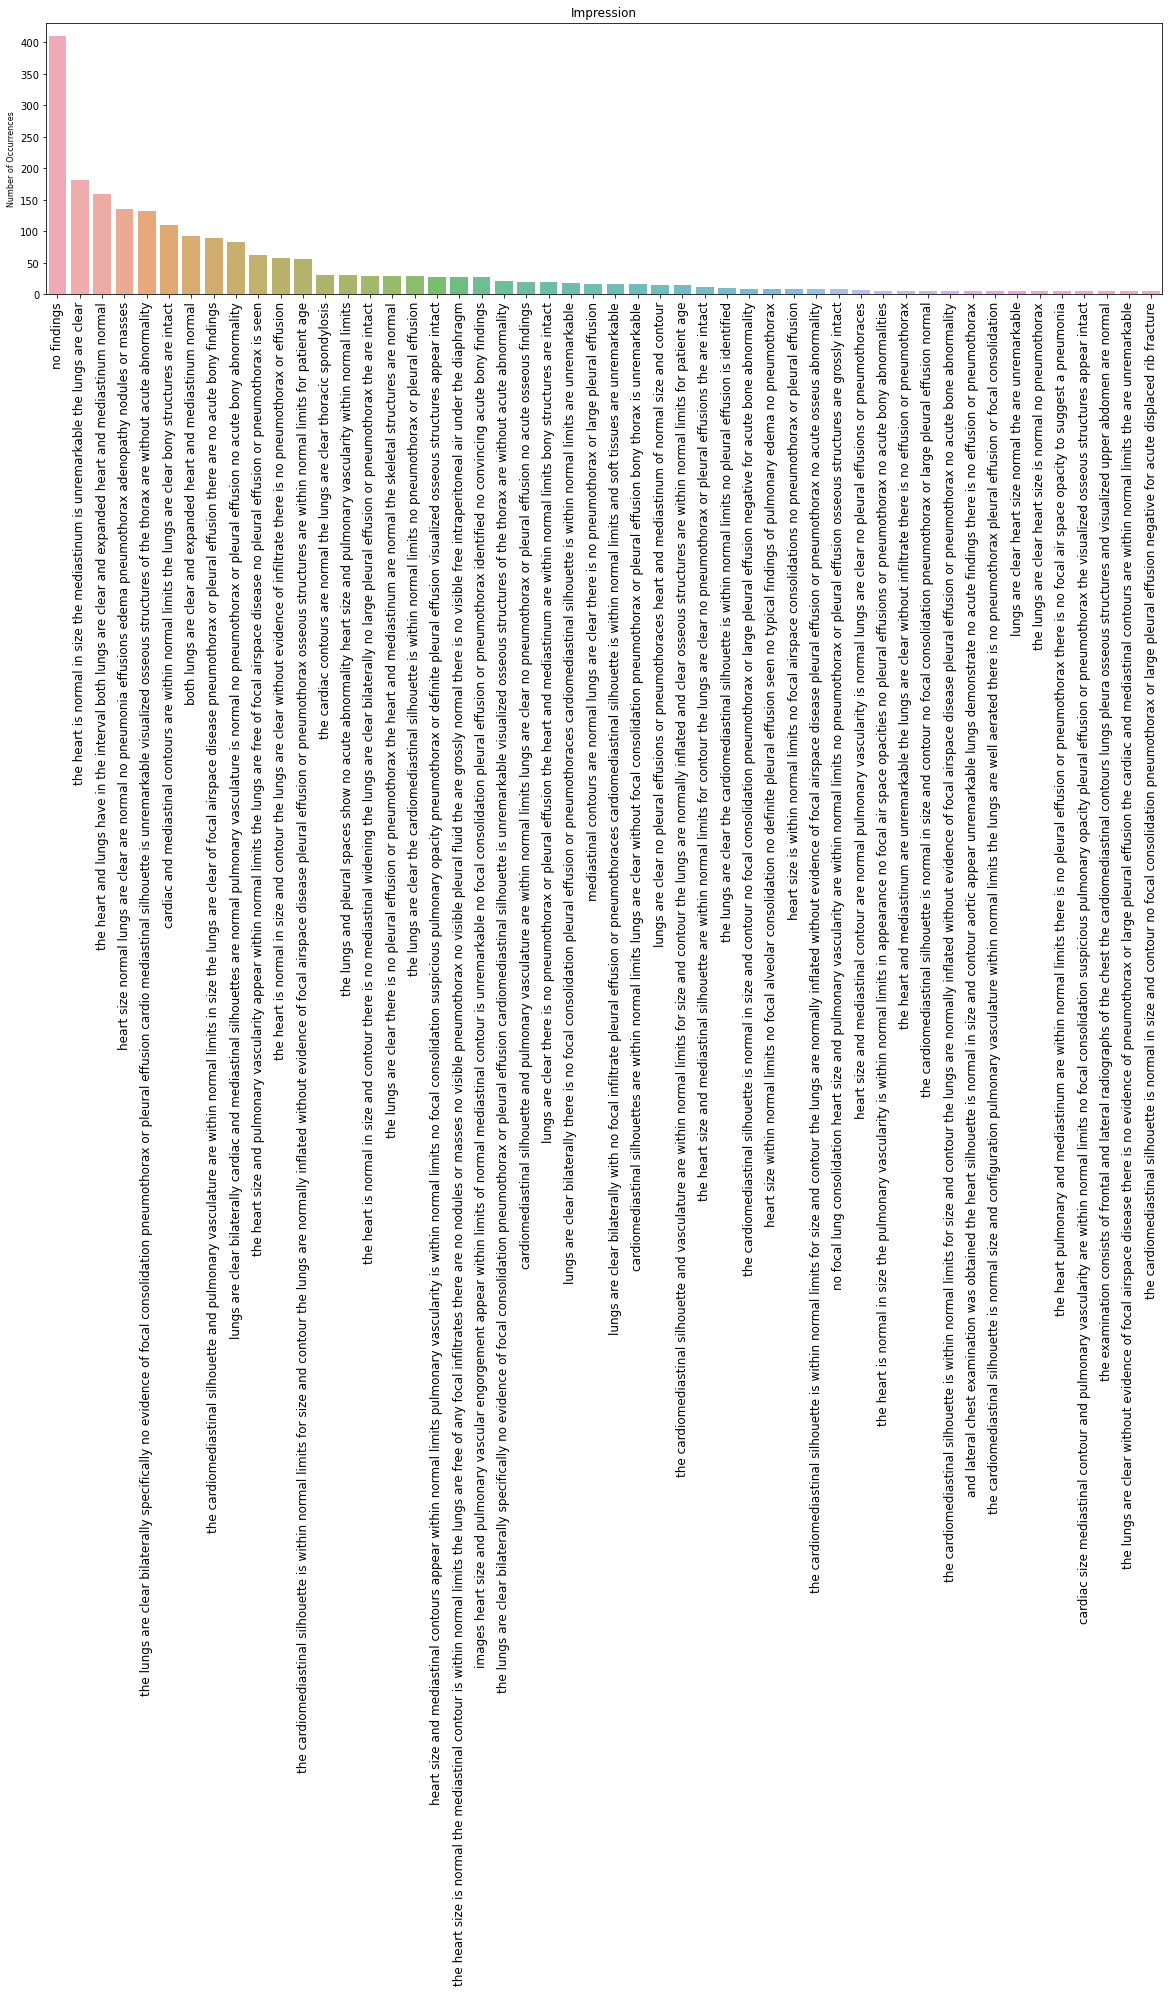

In [53]:
text = df['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(text.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=8)
plt.xticks(fontsize='large',rotation=90)
plt.title("Impression")
plt.show()

# Indication Data analysis

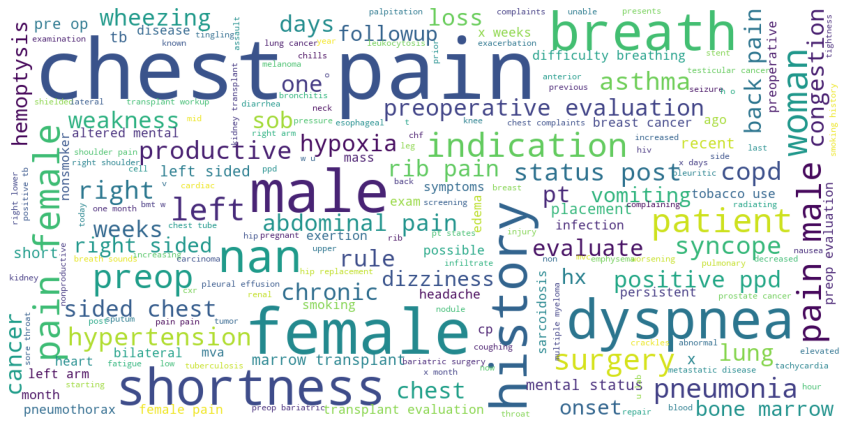

In [54]:
show_wordcloud(df['indication'])